# Functions

In [1]:
from BaconShor3CXheavyhex import BS3CXheavyhex
from utils import build_stim_circuit
import numpy as np

def onlyBS(d, T,logical_prep, offset = -2+6j,
            num_qubits = -1, 
            virt_link = False,
            CXerror= 0, Rerror= 0, singleQerror=0):
    """We still do measurements on the other sublattice, but there are no additional CX layers from the 3CX code"""
    
    code = BS3CXheavyhex(d=d, T=T, logical_prep=['Z',logical_prep], logical_meas=['Z',logical_prep], offset=offset,
                            num_qubits=num_qubits, 
                            virt_link=virt_link,
                            CX_schedule = ['BSZ0', 'BSZ1','BSX1', 'BSX0'],
                            CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror)
    return code

In [71]:
def sample_from_histogram(data, bins, n_samples, seed=42):
    count, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pmf = count / np.sum(count)
    cdf = np.cumsum(pmf)

    np.random.seed(seed)
    random_numbers = np.random.rand(n_samples)
    sampled_indices = np.searchsorted(cdf, random_numbers)

    return bin_centers[sampled_indices]

def adjust_samples_to_match_mean_variance(samples, original_mean, original_variance):
    # Calculate current mean and std deviation of the samples
    samples_mean = np.mean(samples)
    samples_std = np.std(samples)
    
    # Calculate target std deviation from the target variance
    target_std = np.sqrt(original_variance)
    
    # Adjust samples
    adjusted_samples = ((samples - samples_mean) / samples_std) * target_std + original_mean
    
    # # Clip adjusted samples to the range of the original data
    # adjusted_samples_clipped = np.clip(adjusted_samples, 0+1e-5, 0.5-1e-5)

    offset = 1e-4
    mask_below = adjusted_samples < 0
    mask_above = adjusted_samples > 0.5
    random_offsets_below = np.random.uniform(0, offset, mask_below.sum())
    random_offsets_above = np.random.uniform(0, -offset, mask_above.sum())

    adjusted_samples_clipped = adjusted_samples.copy()
    adjusted_samples_clipped[mask_below] = 0 + random_offsets_below
    adjusted_samples_clipped[mask_above] = 0.5 + random_offsets_above
    
    return adjusted_samples_clipped


def sample_from_histogram_and_adjust(data, bins, n_samples, multiplicative_factor = 1, seed=42):
    count, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pmf = count / np.sum(count)
    cdf = np.cumsum(pmf)
    
    np.random.seed(seed)
    random_numbers = np.random.rand(n_samples)
    sampled_indices = np.searchsorted(cdf, random_numbers)
    sampled_data = bin_centers[sampled_indices]
    
    # Adjust the sampled data to match the mean and variance of the original data
    original_mean = np.mean(data) * multiplicative_factor
    original_variance = np.var(data) * multiplicative_factor**2
    adjusted_samples = adjust_samples_to_match_mean_variance(sampled_data, original_mean, original_variance)
    
    return adjusted_samples

# Get calib data

In [131]:
import pickle

with open('pSoft.pkl', 'rb') as f:
    pSoft = pickle.load(f)

print(pSoft.shape)

with open('msmt_err_dict.pkl', 'rb') as f:
    msmt_err_dict = pickle.load(f)

p_soft_mean = np.mean([v['p_soft'] for v in msmt_err_dict.values()])
p_hard_mean = np.mean([v['p_hard'] for v in msmt_err_dict.values()])
print(f"p_soft_mean = {p_soft_mean}")
print(f"p_hard_mean = {p_hard_mean}")

(7920355,)
p_soft_mean = 0.0058745117490234975
p_hard_mean = 0.01990728981457963


In [132]:
print(f"mean p_soft = {np.mean(pSoft)}")
print(f"std p_soft = {np.std(pSoft)}")

mean p_soft = 0.005540657327526531
std p_soft = 0.03663705102884955


# Get stim circ

In [54]:
d = 7
T = d

code = onlyBS(d=d, T=T, logical_prep = 'Z' , CXerror=0, Rerror=0.1, singleQerror=0.2)
stim_circuit,relevant_nodes = build_stim_circuit(code,return_relevant_nodes=True)
stim_DEM = stim_circuit.detector_error_model(decompose_errors=True, approximate_disjoint_errors=True, ignore_decomposition_failures=False)

In [55]:
# Get the num

num_needed_samples = 0
for instr in stim_circuit:
    if instr.name == 'PAULI_CHANNEL_1':
        if instr.gate_args_copy()[1] == 0 and instr.gate_args_copy()[2] == 0: # weird after H msmts error 
            num_needed_samples += len(instr.targets_copy())
    if instr.name == 'M':
        num_needed_samples += len(instr.targets_copy())
    # if instr.name == 'R':
    #     num_needed_samples += len(instr.targets_copy())
            
print(f"num_needed_samples = {num_needed_samples}")

num_needed_samples = 2836


In [56]:
arg_list = sample_from_histogram(pSoft.flatten(), bins=int(1e3), n_samples=num_needed_samples, seed=42)
arg_list2 = sample_from_histogram_and_adjust(pSoft.flatten(), bins=int(1e3), n_samples=num_needed_samples, seed=42)

print(f"mean arg_list = {np.mean(arg_list)}")
print(f"std arg_list = {np.std(arg_list)}")

print()

print(f"mean arg_list2 = {np.mean(arg_list2)}")
print(f"std arg_list2 = {np.std(arg_list2)}")

arg_list = arg_list2

mean arg_list = 0.008793128118480214
std arg_list = 0.04493761074955821

mean arg_list2 = 0.008709376534839983
std arg_list2 = 0.045726291766478


In [57]:
print(len(arg_list))

2836


In [59]:
import stim

sample_idx = 0
soft_stim_circuit = stim.Circuit()
for instr in stim_circuit:
    if instr.name == 'PAULI_CHANNEL_1':
        if instr.gate_args_copy()[1] == 0 and instr.gate_args_copy()[2] == 0: # weird after H msmts error 
            for target in instr.targets_copy():
                arg_el = arg_list[sample_idx]
                sample_idx += 1
                arg = instr.gate_args_copy()[0] + arg_el - 2*instr.gate_args_copy()[0]*arg_el
                soft_stim_circuit.append(instr.name, [target], [arg, 0, 0])
    elif instr.name == 'M':
        for target in instr.targets_copy():
            arg_el = arg_list[sample_idx]
            sample_idx += 1
            soft_stim_circuit.append(instr.name, [target], [arg_el])
    else:
        soft_stim_circuit.append(instr.name, instr.targets_copy(), instr.gate_args_copy())

print(soft_stim_circuit)

H 7 9 11 13 22 24 26 27 35 37 39 41 50 52 54 55 63 65 67 69 78 80 82 83 152 153 154 155 156 157 158 165 166 167 168 169 170 171 178 179 180 181 182 183 184 191 192 193 194 195 196 197 204 205 206 207 208 209 210 217 218 219 220 221 222 223
CX 7 97 152 7 7 97 152 7 8 98 153 8 8 98 153 8 9 99 154 9 9 99 154 9 10 100 155 10 10 100 155 10 11 101 156 11 11 101 156 11 12 102 157 12 12 102 157 12 13 103 158 13 13 103 158 13 21 104 165 21 21 104 165 21 22 105 166 22 22 105 166 22 23 106 167 23 23 106 167 23 24 107 168 24 24 107 168 24 25 108 169 25 25 108 169 25 26 109 170 26 26 109 170 26 27 110 171 27 27 110 171 27 35 111 178 35 35 111 178 35 36 112 179 36 36 112 179 36 37 113 180 37 37 113 180 37 38 114 181 38 38 114 181 38 39 115 182 39 39 115 182 39 40 116 183 40 40 116 183 40 41 117 184 41 41 117 184 41 49 118 191 49 49 118 191 49 50 119 192 50 50 119 192 50 51 120 193 51 51 120 193 51 52 121 194 52 52 121 194 52 53 122 195 53 53 122 195 53 54 123 196 54 54 123 196 54 55 124 197 55 55 12

# Get amplified arg list

In [110]:
# Get the ratio

pSratio = p_soft_mean / (p_soft_mean + p_hard_mean)
pHratio = p_hard_mean / (p_soft_mean + p_hard_mean)

p_err = 0.1  # wanted p_err
pH = p_err * pHratio
pSmean = p_err * pSratio

mult_factor = pSmean / np.mean(pSoft)
mult_fac = 10
arg_list = sample_from_histogram_and_adjust(pSoft.flatten(), bins=int(1e4), n_samples=100, 
                                            multiplicative_factor=mult_fac, seed=42)

print(f"pSatio = {pSratio}")
print(f"pHratio = {pHratio}")
print(f"pH = {pH}")
print(f"pSmean = {pSmean}")

print(f"mult_factor = {mult_factor}")

print(f"mean arg_list = {np.mean(arg_list)}")
print(f"std arg_list = {np.std(arg_list)}")

pSatio = 0.25260219460406547
pHratio = 0.7473978053959344
pH = 0.07473978053959345
pSmean = 0.025260219460406547
mult_factor = 2.978668930119089
mean arg_list = 0.03309376974370047
std arg_list = 0.11411199741320624


In [116]:
factors = np.linspace(0.1, 20, 100)
means = [np.mean(sample_from_histogram_and_adjust(pSoft.flatten(), bins=int(3e4), 
                                                  n_samples=1000, multiplicative_factor=mult_factor)) for mult_factor in factors]

In [117]:
stds = [np.std(sample_from_histogram_and_adjust(pSoft.flatten(), bins=int(3e4),
                                                n_samples=1000, multiplicative_factor=mult_factor)) for mult_factor in factors]

Text(0.5, 0, 'multiplicative factor')

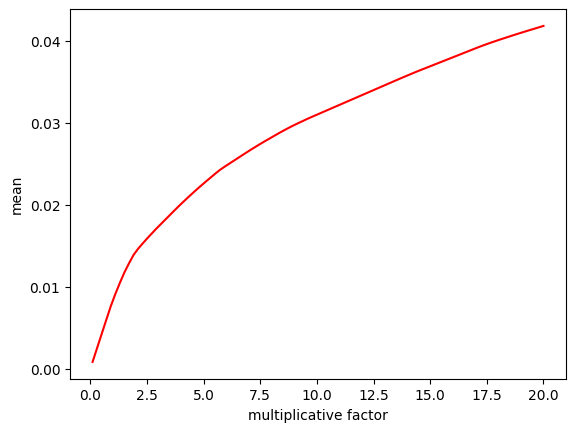

In [130]:
import matplotlib.pyplot as plt

ratios = [mean/std for mean, std in zip(means, stds)]

plt.plot(factors, means, color='red')
# plt.plot(factors, stds, color='blue')
# plt.plot(factors, ratios, color='green')
# plt.xlim(0, 1)
plt.ylabel('mean')
plt.xlabel('multiplicative factor')